In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import csc_matrix
from readFunctions import openFile
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
data = openFile('../Data/All_Beauty_5.json.gz')


In [3]:
data.head()


,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,5.0,True,"09 1, 2016",A3CIUOJXQ5VDQ2,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",Shelly F,As advertised. Reasonably priced,Five Stars,1472688000,NaN,NaN
1,5.0,True,"11 14, 2013",A3H7T87S984REU,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",houserules18,Like the oder and the feel when I put it on my...,Good for the face,1384387200,NaN,NaN
2,1.0,True,"08 18, 2013",A3J034YH7UG4KT,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",Adam,I bought this to smell nice after I shave. Wh...,Smells awful,1376784000,NaN,NaN
3,5.0,False,"05 3, 2011",A2UEO5XR3598GI,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",Rich K,HEY!! I am an Aqua Velva Man and absolutely lo...,Truth is There IS Nothing Like an AQUA VELVA MAN.,1304380800,25,NaN
4,5.0,True,"05 6, 2011",A3SFRT223XXWF7,B00006L9LC,{'Size:': ' 200ml/6.7oz'},C. C. Christian,If you ever want to feel pampered by a shampoo...,Bvlgari Shampoo,1304640000,3,NaN


In [4]:
print("Mean rating : {}".format(data['overall'].mean()))
print("Mean rating standard deviation: {}".format(data['overall'].std()))


Mean rating : 4.771873220724995
Mean rating standard deviation: 0.74320403799122


Text(0, 0.5, 'count of reviews')

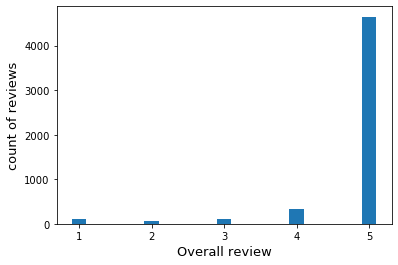

In [5]:
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
ax.hist(data['overall'], bins=[0.9, 1.1, 1.9, 2.1, 2.9, 3.1, 3.9, 4.1, 4.9, 5.1])
ax.set_xlabel('Overall review', fontsize=13)
ax.set_ylabel('count of reviews', fontsize=13)


In [6]:
num_users = len(data['reviewerID'].unique())
num_items = len(data['asin'].unique())

print("Number of reviewers: {}".format(num_users))
print("Number of products : {}".format(num_items))
print("Number of ratings  : {}".format(len(data)))

avg_num_reviews = data.groupby('reviewerID')['asin'].count()
print("Avg Number of ratings per reviewer {}".format(avg_num_reviews.mean()))


Number of reviewers: 991
Number of products : 85
Number of ratings  : 5269
Avg Number of ratings per reviewer 5.316851664984863


Text(0, 0.5, 'number of reviewers')

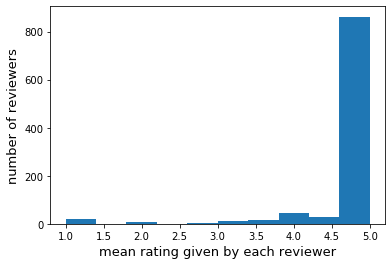

In [7]:
mean_rating_of_user = data.groupby('reviewerID').apply(lambda x: x['overall'].mean())

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
ax.hist(mean_rating_of_user)
ax.set_xlabel('mean rating given by each reviewer', fontsize=13)
ax.set_ylabel('number of reviewers', fontsize=13)

In [8]:
# turn each reviewer and product into categorical data,
data['reviewerID'] = data['reviewerID'].astype("category")
data['asin'] = data['asin'].astype("category")

reviews = csc_matrix((data['overall'].astype(float),
                      (data['reviewerID'].cat.codes,
                       data['asin'].cat.codes)))
print(reviews.shape)


(991, 85)


In [9]:
ratings_matrix = reviews.toarray()

sparsity = float(len(ratings_matrix.nonzero()[0]))
sparsity /= (ratings_matrix.shape[0] * ratings_matrix.shape[1])
sparsity *= 100
print("Sparsity: {:4.2f}%".format(sparsity))


Sparsity: 4.86%


In [10]:
mean_rating = data['overall'].mean()
base_rmse = np.sqrt(pow(data['overall'] - mean_rating, 2).mean())
print("RMSE = {}".format(base_rmse))




RMSE = 0.7431335085449885


## User-User Collaborative Filtering using Cosine Similarity

In [11]:
def User_User_CF(reviews):
    """
    Obtains the RMSE error in the user-user collaborative
    filtering algorithms using all the similar users.

    :param: reviews (numpy.ndarray) : The dense user-item matrix.

    :returns: RMSE of predictions
    :rvalue: float
    """

    # Get the user-user similarity matrix
    user_user_similarity = cosine_similarity(reviews)    
    print('user user similarity', user_user_similarity.shape)

    sqdiffs = 0
    num_preds = 0

    # to protect against divide by zero issues
    eps = 1e-6

    cnt_no_sims = 0
    # loop over the users
    for user_i, u in enumerate(reviews):

        # products user HAS rated
        i_rated = np.where(u > 0)[0]

        # Get the average rating for this user
        user_avg = i_rated.mean()

        # loop over all the products that each user reviewed
        # Note: these are all the non-zero entries in the row
        for i_product in i_rated:

            # Get all the users (indices) that
            # have also reviewed this product.
            # Note: This also includes the user of interest!
            i_has_rated = np.where(reviews[:, i_product])[0]

            # remove the user (indices) of interest
            # from this column
            i_remove = np.argmin(abs(i_has_rated - user_i))
            i_others_have_rated = np.delete(i_has_rated, i_remove)

            # Get the ratings for product by the similar users,
            ratings = reviews[i_others_have_rated,
                              i_product]

            ratings -= user_avg

            # get the cosine similarity between the users
            # and other users.
            similarities = user_user_similarity[user_i,
                                                i_others_have_rated]

            # denominator of user_i's produdct prediction
            norm = np.sum(similarities)
            if norm == 0:
                cnt_no_sims += 1
                norm = eps

            # prediction of user u on product i: p_{u,i}
            predicted_rating = user_avg + np.sum(np.multiply(
                ratings.T,
                similarities)) / norm

            # actual rating by user u on product i
            actual_rating = reviews[user_i, i_product]

        # get the L2 difference in predicted and actual
        # rating for the user
        sqdiffs += pow(predicted_rating - actual_rating, 2.0)
        num_preds += 1

    # get the average of all the predictions
    rmse_cossim = np.sqrt(sqdiffs / num_preds)
    return rmse_cossim


user_all_rmse = User_User_CF(ratings_matrix)
print('User-User CF RMSE for all users:', user_all_rmse)


user user similarity (991, 991)
User-User CF RMSE for all users: 3.336838280454295


In [12]:
def User_User_CF_TopN(reviews, N):
    """
    Obtains the RMSE error in the user-user collaborative
    filtering algorithms using the top N most similar users.

    :param: reviews (numpy.ndarray) : The dense user-item matrix.
    :param: N (int) : The number of the most similar users.

    :returns: RMSE of predictions
    :rvalue: float
    """

    # Get the user-user similarity matrix
    user_user_similarity = cosine_similarity(reviews)

    sqdiffs = 0
    num_preds = 0

    # to protect against divide by zero issues
    eps = 1e-6

    cnt_no_sims = 0
    # loop over the users
    for user_i, u in enumerate(reviews):

        # products user HAS rated
        i_rated = np.where(u > 0)[0]

        # Get the average rating for this user
        user_avg = i_rated.mean()

        # loop over all the products that each user reviewed
        # Note: these are all the non-zero entries in the row
        for i_product in i_rated:

            # Get all the users (indices) that
            # have also reviewed this product.
            # Note: This also includes the user of interest!
            i_has_rated = np.where(reviews[:, i_product] > 0)[0]

            # remove the user (indices) of interest
            # from this column
            i_remove = np.argmin(abs(i_has_rated - user_i))
            i_others_have_rated = np.delete(i_has_rated, i_remove)

            # Get the ratings for product by the similar users,
            ratings = reviews[i_others_have_rated,
                              i_product]

            ratings -= user_avg

            # get the cosine similarity between the users
            # and other users.
            sims = user_user_similarity[user_i,
                                        i_others_have_rated]

            # choose top N most similar users
            most_similar_users = sims[np.argsort(sims * -1)][:N]
            most_similar_ratings = ratings[np.argsort(sims * -1)][:N]

            # denominator of user_i's produdct prediction
            norm = np.sum(most_similar_users)
            if norm == 0:
                cnt_no_sims += 1
                norm = eps

            # prediction of user u on product i: p_{u,i}
            predicted_rating = user_avg + np.sum(np.multiply(
                most_similar_ratings.T,
                most_similar_users)) / norm

            # actual rating by user u on product i
            actual_rating = reviews[user_i, i_product]

        # get the L2 difference in predicted and actual
        # rating for the user
        sqdiffs += pow(predicted_rating - actual_rating, 2.0)
        num_preds += 1

    # get the average of all the predictions
    rmse_cossim = np.sqrt(sqdiffs / num_preds)
    return rmse_cossim


N_users = [1, 2, 3, 4, 5, 10, 25, 50]
top_N = [User_User_CF_TopN(ratings_matrix, i) for i in N_users]
print('top n:', top_N)


top n: [3.2245514554429415, 2.9074616267559446, 2.8149366250018413, 2.796117845969906, 2.9136905360965226, 3.0682470053510316, 3.0446225555526403, 3.188013344815447]


Text(0.5, 1.0, 'RMSE Error In Recommender Predictions')

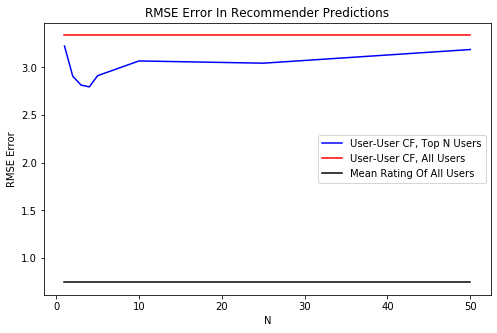

In [13]:
# make constant vectors
user_all = []
mean_all = []
for i in range(len(N_users)):
    user_all.append(user_all_rmse)
    mean_all.append(base_rmse)

plt.figure(figsize=(8, 5))
plt.plot(N_users, top_N, 'b', label='User-User CF, Top N Users')
plt.plot(N_users, user_all, 'r', label='User-User CF, All Users')
plt.plot(N_users, mean_all, 'k', label='Mean Rating Of All Users')
plt.xlabel('N')
plt.ylabel('RMSE Error')
plt.legend()
plt.title('RMSE Error In Recommender Predictions')



## User based Collaborative Filtering Model using Singular Value Decomposition 



In [14]:
df = pd.DataFrame()
df['userId'] = data['reviewerID']
df['productId'] = data['asin']
df['ratings'] = data['overall']

In [15]:
print(df['ratings'].describe())

count    5269.000000
mean        4.771873
std         0.743204
min         1.000000
25%         5.000000
50%         5.000000
75%         5.000000
max         5.000000
Name: ratings, dtype: float64


In [16]:
final_ratings_matrix = df.pivot_table(index='userId', columns='productId', values='ratings', aggfunc=np.mean).fillna(0)
print(final_ratings_matrix.head())

productId       B0000530HU  B00006L9LC  B00021DJ32  B0002JHI1I  B0006O10P4  \
userId                                                                       
A105A034ZG9EHO         0.0         0.0         0.0         0.0         0.0   
A10JB7YPWZGRF4         0.0         0.0         0.0         0.0         0.0   
A10M2MLE2R0L6K         0.0         0.0         0.0         0.0         0.0   
A10P0NAKKRYKTZ         0.0         0.0         0.0         0.0         0.0   
A10ZJZNO4DAVB          0.0         5.0         0.0         0.0         0.0   

productId       B0009RF9DW  B000FI4S1E  B000FOI48G  B000FTYALG  B000GLRREU  \
userId                                                                       
A105A034ZG9EHO         5.0         5.0         0.0         0.0         0.0   
A10JB7YPWZGRF4         5.0         5.0         0.0         0.0         0.0   
A10M2MLE2R0L6K         0.0         0.0         0.0         0.0         0.0   
A10P0NAKKRYKTZ         5.0         5.0         0.0         0.0 

In [17]:
# Calculating density which is same as sparsity
# given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
# print('given_num_of_ratings', given_num_of_ratings)
# possible_nums_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
# print('possible_nums_of_ratings', possible_nums_of_ratings)
# density = (given_num_of_ratings/possible_nums_of_ratings) * 100
# print('density:', density)



In [18]:
# final_ratings_matrix['user_index'] = np.arange(0, final_ratings_matrix.shape[0], 1)
# final_ratings_matrix.set_index(['user_index'], inplace=True)
print(final_ratings_matrix.head())

productId       B0000530HU  B00006L9LC  B00021DJ32  B0002JHI1I  B0006O10P4  \
userId                                                                       
A105A034ZG9EHO         0.0         0.0         0.0         0.0         0.0   
A10JB7YPWZGRF4         0.0         0.0         0.0         0.0         0.0   
A10M2MLE2R0L6K         0.0         0.0         0.0         0.0         0.0   
A10P0NAKKRYKTZ         0.0         0.0         0.0         0.0         0.0   
A10ZJZNO4DAVB          0.0         5.0         0.0         0.0         0.0   

productId       B0009RF9DW  B000FI4S1E  B000FOI48G  B000FTYALG  B000GLRREU  \
userId                                                                       
A105A034ZG9EHO         5.0         5.0         0.0         0.0         0.0   
A10JB7YPWZGRF4         5.0         5.0         0.0         0.0         0.0   
A10M2MLE2R0L6K         0.0         0.0         0.0         0.0         0.0   
A10P0NAKKRYKTZ         5.0         5.0         0.0         0.0 

In [19]:
new_df = pd.DataFrame(final_ratings_matrix)
new_df.columns = new_df.columns.astype(list)
print(new_df.reset_index())

productId          userId  B0000530HU  B00006L9LC  B00021DJ32  B0002JHI1I  \
0          A105A034ZG9EHO         0.0         0.0         0.0         0.0   
1          A10JB7YPWZGRF4         0.0         0.0         0.0         0.0   
2          A10M2MLE2R0L6K         0.0         0.0         0.0         0.0   
3          A10P0NAKKRYKTZ         0.0         0.0         0.0         0.0   
4           A10ZJZNO4DAVB         0.0         5.0         0.0         0.0   
..                    ...         ...         ...         ...         ...   
986         AZCOSCQG73JZ1         0.0         5.0         0.0         0.0   
987         AZD3ON9ZMEGL6         0.0         0.0         0.0         0.0   
988         AZFYUPGEE6KLW         0.0         5.0         0.0         0.0   
989         AZJMUP77WBQZQ         0.0         5.0         0.0         0.0   
990         AZRD4IZU6TBFV         0.0         0.0         0.0         0.0   

productId  B0006O10P4  B0009RF9DW  B000FI4S1E  B000FOI48G  B000FTYALG  ... 

In [20]:
from scipy.sparse.linalg import svds

# Singular Value Decomposition
U, sigma, Vt = svds(new_df, k = 10)

In [21]:
print('Left Signular Matrix', U)

Left Signular Matrix [[-6.62869684e-03 -3.13147591e-05  2.22049707e-04 ... -1.99327586e-06
  -3.98660087e-02  3.29244749e-02]
 [-6.62869684e-03 -3.13147591e-05  2.22049707e-04 ... -1.99327586e-06
  -3.98660087e-02  3.29244749e-02]
 [-2.73067631e-03  6.67635049e-02  3.04372272e-04 ... -1.29304945e-01
   4.33612297e-05  1.56217571e-05]
 ...
 [-1.84574142e-03  2.42874997e-04 -9.27894916e-03 ...  2.33442112e-04
   2.95369913e-02  3.63442477e-02]
 [-1.84574142e-03  2.42874997e-04 -9.27894916e-03 ...  2.33442112e-04
   2.95369913e-02  3.63442477e-02]
 [-6.62869684e-03 -3.13147591e-05  2.22049707e-04 ... -1.99327586e-06
  -3.98660087e-02  3.29244749e-02]]


In [22]:
print('Sigma:', sigma)
# Construct diagonal array in SVD
sigma = np.diag(sigma)
print('Diagonal Matrix:', sigma)

Sigma: [ 20.1701175   21.88733657  22.23958436  22.63511253  23.7345597
  27.58570695  30.35810089  53.17711442 143.43496984 249.05139135]
Diagonal Matrix: [[ 20.1701175    0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.          21.88733657   0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.          22.23958436   0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.          22.63511253   0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.          23.7345597
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
   27.58570695   0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.          

In [23]:
print('Right Signular Matrix', Vt)

Right Signular Matrix [[-3.04098886e-04  2.21703553e-01  4.01230938e-02  1.50478576e-04
   2.14783273e-03  2.24536999e-01  2.24536999e-01  9.84188998e-04
  -3.04098886e-04  9.84188998e-04 -4.34799817e-04 -2.27200652e-03
   2.90575902e-02 -8.02091949e-01  2.10154017e-03 -2.84678831e-05
  -2.93855399e-03 -9.17341925e-05 -4.70008722e-04  3.96768114e-02
  -8.51894644e-04  3.07406708e-02  2.12640602e-15  1.51651192e-02
  -1.79401992e-02 -2.80736601e-04  1.50478576e-04 -4.87500542e-04
  -1.03014092e-04  3.26277632e-01 -6.60586155e-04  5.07650158e-02
   7.98823925e-15 -1.66375312e-02  1.57233093e-03  2.55486131e-02
   3.69356309e-04 -1.10260895e-03 -1.73876348e-03 -9.65169565e-04
   2.46665000e-01 -1.50132430e-04 -5.35750670e-03 -3.83819167e-04
   1.55846156e-01 -3.57613020e-03  1.25555623e-03  3.83862641e-02
  -3.30237558e-03  4.07673802e-04 -6.39698191e-04 -3.30634216e-15
  -1.18599747e-02  1.65160524e-04 -3.57613020e-03 -2.96976874e-03
  -2.58568372e-02  2.31160476e-03 -4.87439877e-03  8.6

In [24]:
# Predicted ratings

all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt)
predicted_df = pd.DataFrame(all_user_predicted_ratings, columns=new_df.columns)


In [25]:
def recommend_items(userId, new_df, predicted_df, n_recommendations):
    user_idx = userId - 1
    sorted_user_ratings = new_df.iloc[user_idx].sort_values(ascending=False)
    sorted_user_predictions = predicted_df.iloc[user_idx].sort_values(ascending=False)
    temp_df = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp_df.index.name = 'Recommended Items'
    temp_df.columns = ['user_ratings', 'user_predictions']
    temp_df = temp_df.sort_values('user_predictions', ascending=False)
    print('Recommendations for user:', userId)
    print(temp_df.head(n_recommendations))

In [26]:
userId = 10
n_recommendations = 5
recommend_items(userId, new_df, predicted_df, n_recommendations)


Recommendations for user: 10
                   user_ratings  user_predictions
Recommended Items                                
B000URXP6E                  0.0      2.261026e-14
B00HLXEXDO                  0.0      9.294365e-16
B00CQ0LN80                  0.0      7.261864e-16
B00IJHY54S                  0.0      7.261864e-16
B00JF2GVWK                  0.0      5.402992e-16
